In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import numpy as np
import torch
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import  torch.nn as nn
import torch.nn.functional as F
rseed = 42
np.random.seed(rseed)
torch.manual_seed(rseed)
gpu_id = '0'
from joblib import Parallel, delayed
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id
os.environ['JOBLIB_TEMP_FOLDER'] = '/ksozykinraid/data/tmp/'
from time import time
import torch 
import pandas as pd
import glob2
import json
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install wldhx.yadisk-direct

In [4]:
from google.colab import files
files.upload()

Saving datasets.py to datasets.py
Saving layers.py to layers.py
Saving utils.py to utils.py


{'datasets.py': b'\nfrom utils import *\nimport torch.utils.data\nfrom sklearn.model_selection import train_test_split\n#from ipypb import ipb\nfrom tqdm import tqdm\n\nrseed = 42\n\nclass pamap2Dataset(torch.utils.data.Dataset):\n    \n    """\n        \n    """\n    def __init__(self,subjects,fold=\'train\',\n                 win_size=256,step=128,\n                 num_classes = 4,\n                 test_subject = 6,\n                 val_rate = 0.3):\n        """\n        """\n        self.data = []\n        self.labels = []\n        self.test_data = []\n        self.test_labels = []\n        self.win_size = win_size\n        self.step = step\n        \n        self.fold = fold\n        \n        \n        for i in tqdm(range(len(subjects))):\n            #data = []\n            #labels = []\n            subject = subjects[i]\n            for window in sliding_window(subject[useful_columns],win_size = self.win_size,\n                                         step=self.step):\n      

In [0]:
from utils import *
from datasets import *
from layers import *
from wldhx import yadisk_direct

In [6]:
!curl -L $(yadisk-direct https://yadi.sk/d/lxgnGR5Sf8VhHg) -o PAMAP2_Dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  753M    0  753M    0     0  2366k      0 --:--:--  0:05:26 --:--:--  980k


## Datasets

In [0]:
!mkdir data
!mkdir data/sensors
!mv PAMAP2_Dataset.zip data/sensors/PAMAP2_Dataset.zip

In [0]:
data_root = 'data/sensors'
data_fnzip =  "%s/%s" % (data_root , 'PAMAP2_Dataset.zip')
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip'

In [9]:
if not os.path.exists(data_fnzip[:-4]):
    !curl -L $data_url -o $data_fnzip
    !unzip $data_fnzip -d $data_root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  656M  100  656M    0     0  41.1M      0  0:00:15  0:00:15 --:--:-- 43.5M
Archive:  data/sensors/PAMAP2_Dataset.zip
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject101.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject102.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject103.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject104.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject105.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject106.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject107.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject108.dat  
  inflating: data/sensors/PAMAP2_Dataset/Protocol/subject109.dat  
  inflating: data/sensors/PAMAP2_Dataset/Optional/subject101.dat  
  inflating: data/sensors/PAMAP2_Dataset/Optional/s

In [0]:
path2subjets = sorted(glob2.glob('%s/PAMAP2_Dataset/Protocol/*.dat' % data_root))

In [0]:
def pamap_columns():
    """
        https://github.com/NLeSC/mcfly-tutorial/blob/master/utils/tutorial_pamap2.py
    """
    axes = ['x', 'y', 'z']
    IMUsensor_columns = ['temperature'] + \
        ['acc_16g_' + i for i in axes] + \
        ['acc_6g_' + i for i in axes] + \
        ['gyroscope_' + i for i in axes] + \
        ['magnometer_' + i for i in axes] + \
        ['orientation_' + str(i) for i in range(4)]
    columns = ["timestamp", "activityID", "heartrate"] + ["hand_" + s
                                                         for s in IMUsensor_columns] \
        + ["chest_" + s for s in IMUsensor_columns] + ["ankle_" + s
                                                       for s in IMUsensor_columns]
    return columns

In [0]:
#overlap = []
#for i in tqdm(range(n_subjects)):
#    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
#    subject.columns = pamap_columns()
#    overlap.append(subject['activityID'].values)
#overlap = np.hstack(overlap)
#overlap = [num2label[e] for e in np.unique(overlap)[1:]]

In [0]:
demo_activities = "lying,sitting,standing,walking".split(',')

In [0]:
subset_activities = ['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'Nordic walking',
 'ascending stairs',
 'descending stairs',
 'vacuum cleaning',
 'ironing',
 'rope jumping']

In [0]:
all_columns = pamap_columns()

In [0]:
input_channels = len(data_columns)

In [0]:
win_size = 256
step = 128

In [0]:
demo_mode = False

In [0]:
activities = demo_activities if demo_mode else  subset_activities

In [19]:
subjects = []
n_subjects = len(path2subjets)
for i in tqdm(range(n_subjects)):
    subject = pd.read_csv(path2subjets[i],header=None,sep=' ')
    subject.columns = pamap_columns()
    subject = subject[subject['activityID'].isin([label2num[a] for a in activities])]
    subject['activityID'] =  subject['activityID'].apply(lambda a: activities.index(num2label[a]))
    subject = subject[useful_columns]
    if len(subject) > 0:
        subject = subject.fillna(0)
        #subject = subject.iloc[:min_len]
        subjects.append(subject)

100%|██████████| 9/9 [00:26<00:00,  2.39s/it]


In [0]:
num_classes = len(activities)

In [21]:
train_dataset = pamap2Dataset(subjects,fold='train',num_classes=num_classes,win_size=win_size,step=step)
val_dataset = pamap2Dataset(subjects,fold='val',num_classes=num_classes,win_size=win_size)
test_dataset = pamap2Dataset(subjects,fold='test',num_classes=num_classes,test_subject = 6,win_size=win_size,step=step)

100%|██████████| 9/9 [00:24<00:00,  2.77s/it]


In [23]:
len(train_dataset),len(val_dataset),len(test_dataset)

(9342, 4005, 1817)

In [0]:
#train_lb = np.argmax(train_dataset.labels,-1)
#val_lb = np.argmax(val_dataset.val_labels,-1)

In [0]:
#plt.hist(train_lb)

# Models

In [0]:
class Conv1DNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(256*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [0]:
class MultiSincNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        #self.gpool = GlobalMaxPooling()
        self.fc1 = nn.Linear(7936,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
             Flatten(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input)
        return self.classifier(features)

In [0]:
class Conv1DLstmNet(nn.Module):
    
    def __init__(self):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv11 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(2*win_size*(win_size//(2**3)),512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.conv11,self.pool11,
             nn.ReLU(),                            
             self.conv21,self.pool21,
             nn.ReLU(),
             self.conv31,self.pool31,
             nn.ReLU(),
        )
        

        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.ReLU(),
             self.fc2,
             nn.ReLU(),
             self.logit,
        )
        
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

In [0]:
class MultiSincLstmNet(nn.Module):
    
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.fs = fs
        self.device = device
        self.sincconv = multichannel_sinc_conv(Filt_dim=Filt_dim,
                                  N_channels=input_channels,
                                  N_filt=N_filt,
                                  fs=fs,
                                  device = device)
        self.layer_norm = LayerNorm(win_size-Filt_dim+1)
        self.conv11 = nn.Conv1d(in_channels=324, out_channels=64, kernel_size=3, padding=1)
        self.pool11 = nn.MaxPool1d(kernel_size=2)
        self.conv21 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool21 = nn.MaxPool1d(kernel_size=2)
        self.conv31 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool31 = nn.MaxPool1d(kernel_size=2)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=512,batch_first=True)
        self.fc1 = nn.Linear(7936*2,512)
        self.fc2 = nn.Linear(512,512)
        self.logit = nn.Linear(512,num_classes)
        
        self.features = nn.Sequential(
             self.input_bn,
             self.sincconv,
             #self.layer_norm,
             self.conv11,
             nn.LeakyReLU(),
             self.pool11,
             nn.LeakyReLU(),                            
             self.conv21,self.pool21,
             nn.LeakyReLU(),
             self.conv31,self.pool31,
             nn.LeakyReLU(),
        )
        
        self.classifier = nn.Sequential(
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        

                
    def forward(self,input):
        features = self.features(input).transpose(1, 2)
        features, (hn,cn) = self.lstm1(features)
        features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(features)

In [0]:
def roll2(x, n):  
    return torch.cat((x[:, :, -n:], x[:, :, :-n]), dim=2)

In [0]:
class get_features_isotropy(nn.Module):

    def __init__(self, hidden_ch=32, krnl=32):
        super(get_features_isotropy,self).__init__()
        self.hidden_ch = hidden_ch
        self.conv1 = nn.Conv1d(9, hidden_ch, krnl)
        self.fc1 = nn.Conv1d(hidden_ch, 1, 1)
        self.fc2 = nn.Conv1d(hidden_ch, 1, 1)
        self.conv2 = nn.Conv1d(12, hidden_ch, krnl)
        self.krnl = krnl

    def forward(self, x):
        h = x.clone().reshape(-1, 27, win_size).transpose(1, 2).reshape(-1, win_size, 3, 3, 3) # we will leave only the acceleration rows unchanged
        h1 = h.clone()
        for body_part in range(3):
            for orientation in range(3):
                h1[:, :, body_part, 1, orientation] = self.fc1(F.leaky_relu(self.conv1(F.pad(roll2(h[:, :, body_part], orientation).reshape(-1, win_size, 9), (0, 0, self.krnl-1, 0)).transpose(1, 2)))).reshape(-1, win_size)
        h = torch.cat((h, h1[:, :, :, 1:2, :]), dim=3)
        for body_part in range(3):
            for orientation in range(3):
                h1[:, :, body_part, 2, orientation] = self.fc2(F.leaky_relu(self.conv2(F.pad(roll2(h[:, :, body_part], orientation).reshape(-1, win_size, 12), (0, 0, self.krnl-1, 0)).transpose(1, 2)))).reshape(-1, win_size)
        #return h1.reshape(-1, win_size, 27).transpose(1, 2).contiguous()
        return h1.reshape(-1, win_size*27)

In [0]:
class IsotropyNet(nn.Module):
    
    def __init__(self, krnl=32,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.device = device
        self.isotropic_features = get_features_isotropy(krnl=krnl)
        self.fc1 = nn.Linear(27*256, 512)
        self.fc2 = nn.Linear(512, 64)
        #self.lstm1 = nn.LSTM(input_size=win_size,hidden_size=512,batch_first=True)
        self.logit = nn.Linear(64,num_classes)
        
        self.classifier = nn.Sequential(
             self.input_bn,
             self.isotropic_features,
             #Flatten(),
             self.fc1,
             nn.LeakyReLU(),
             self.fc2,
             nn.LeakyReLU(),
             self.logit,
        )
        

                
    def forward(self,input):
        #features = self.features(input).transpose(1, 2)
        #features, (hn,cn) = self.lstm1(features)
        #features = Flatten()(features.transpose(1, 2).contiguous())
        return self.classifier(input)

In [0]:

class IsotropyMultiSincLstmNet(nn.Module):
    def __init__(self,
                 N_filt = 12,  
                 Filt_dim = 5, 
                 fs = 100,
                 device = "cuda"):
        super(self.__class__, self).__init__()
        self.isotropy = get_features_isotropy()
        self.net = MultiSincLstmNet(N_filt = N_filt, Filt_dim = Filt_dim, fs = fs, device = device)
    def forward(self,input):
        print(self.isotropy(input.transpose(1, 2)).shape)
        return self.net(self.isotropy(input))

In [0]:

class IsotropyConv1DNet(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.isotropy = get_features_isotropy()
        self.net = Conv1DNet()
    def forward(self,input):
        return self.net(self.isotropy(input.transpose(1, 2)).transpose(1, 2))

## Debug

In [29]:
device = 'cuda'
batch_size = 1
model = IsotropyNet().to(device)
dummy_batch = train_dataset.train_data[:batch_size]
dummy_batch = torch.tensor(dummy_batch).transpose(2,1)
prediction = model(dummy_batch.to(device))
del model
del dummy_batch
print(prediction.shape)
del prediction
torch.cuda.empty_cache()

torch.Size([1, 12])


## Experiments

In [0]:
!mkdir har-models

In [0]:
num_epochs = 50
verbose = 5
batch_size = 1024
device = "cuda"

In [0]:

def compute_loss(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    reference = torch.argmax(reference,dim=-1).to(torch.long)
    prediction = prediction.log_softmax(dim=-1)
    loss = nn.NLLLoss()(prediction,reference)
    return loss
  
def compute_acc(reference, prediction):
    """
    
    """
    reference = reference.to(device)
    prediction = torch.argmax(prediction.log_softmax(dim=-1),dim=-1)
    reference = torch.argmax(reference,dim=-1)
    return (reference == prediction).to(torch.float32).mean()
  
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size*4,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#model = Conv1DNet().to(device)
#model = Conv1DLstmNet().to(device)
#model = MultiSincNet(device=device).to(device)
#model = MultiSincLstmNet(device=device).to(device)
model = IsotropyNet(krnl=32).to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)

best_acc = 0.
best_loss = np.inf
sPATH = ''
fmt_str = 'har-models/%s_%dclass_%.4f.pth'

epoch_wo_progress=0

In [0]:
from collections import  defaultdict
report  = defaultdict(list)

In [0]:
from IPython import display

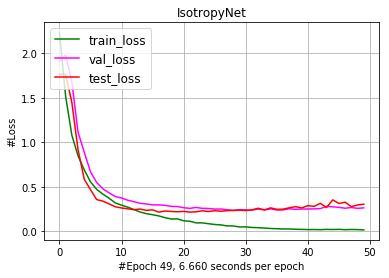

49	Training:
	Loss:	0.01407
	ACC:	0.99700
49	Validation:
	BEST VAL loss:	0.23282
	Loss:	0.26209
	val ACC:	0.93633
49	Testing:
	Loss:	0.15164
	test ACC:	0.93176




In [89]:
batch_size=1024

for epoch in range(num_epochs):
    if epoch==15 or epoch==30:
        batch_size *= 2
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    train_loss = train_acc = train_batches = 0 
    train_acc_fixed = 0
    model.train()
    y_true,y_pred = [],[]
    start = time.time()
    for batch in train_loader:
        
        data,reference = batch
        data = data.transpose(1, 2).to(device)
#        print(data.transpose(1, 2).shape)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    
    with torch.no_grad():
        train_acc += compute_acc(y_true, y_pred).cpu().numpy()
    
    val_loss = val_acc = val_batches = 0
    val_acc_fixed = 0
    #model.train(False)
    model.eval()
    y_true,y_pred = [],[]
    for batch in val_loader:
        data,reference = batch
        
        #reference = torch.cat([reference]*)
        
        data = data.transpose(1, 2).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            val_loss += loss.item()
            
            val_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        val_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #val_acc = (val_acc / val_batches)
    val_loss = (val_loss / val_batches)
    
    y_true,y_pred = [],[]
    test_loss = test_acc = test_batches = 0
    for batch in test_loader:
        data,reference = batch
        data = data.transpose(2,1).to(device)
        prediction = model(data)
        y_true.append(reference)
        y_pred.append(prediction)
        #print(len(reference),len(prediction))
        loss = compute_loss(reference, prediction)
        with torch.no_grad():
            test_loss += loss.item()
            
            test_batches += 1
    y_true = torch.cat(y_true,dim=0)
    y_pred = torch.cat(y_pred,dim=0)
    with torch.no_grad():
        test_acc += compute_acc(y_true, y_pred).cpu().numpy()
    #test_acc = (test_acc / test_batches)
    
    test_loss = (test_loss / test_batches)
    
    
    
    if val_loss < best_loss:
        epoch_wo_progress=0
        best_loss = val_loss
        if sPATH != '' and os.path.exists(sPATH):
            os.remove(sPATH)
        sPATH = fmt_str % (model.__class__.__name__,num_classes,best_loss)
        torch.save(model.state_dict(),sPATH)
    '''else:
        epoch_wo_progress += 1
        if epoch_wo_progress>25:
            print("Early Stopping")
            break'''
    report['train_loss'].append(train_loss / train_batches)
    report['val_loss'].append(val_loss)
    report['test_loss'].append(test_loss)
    finish = time.time()
    time_epoch = finish-start    
    display.clear_output(wait=True)
    fig = plt.Figure(figsize=(20,20),facecolor='white')
    plt.plot(report['train_loss'],color='green',label='train_loss')
    plt.plot(report['val_loss'],color='magenta',label='val_loss')
    plt.plot(report['test_loss'],color='red',label='test_loss')
    plt.xlabel("#Epoch %d, %.3f seconds per epoch" % (epoch,time_epoch))
    plt.ylabel("#Loss")
    plt.title(model.__class__.__name__)
    legend(loc=2, prop={'size': 12})
    plt.grid()
    plt.show()
    
    print("%d\tTraining:" % (epoch))
        
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tACC:\t%.5f" % (train_acc))
    print("%d\tValidation:" % (epoch))
    print("\tBEST VAL loss:\t%.5f" % best_loss)
    print("\tLoss:\t%.5f" % val_loss)
    print("\tval ACC:\t%.5f" % val_acc)
    print("%d\tTesting:" % (epoch))
    print("\tLoss:\t%.5f" % (test_loss / test_batches))
    print("\ttest ACC:\t%.5f" % test_acc)
    print('\n')
    
    
    if epoch  % verbose == 0 or epoch == num_epochs - 1:
        pass

In [0]:
model.load_state_dict(torch.load(sPATH))
model.eval();

## Metrics

In [91]:
reference.shape,prediction.shape

(torch.Size([793, 12]), torch.Size([793, 12]))

In [0]:
y_true_np = torch.argmax(y_true,dim=-1).detach().cpu().numpy()
y_pred_np = torch.argmax(y_pred.log_softmax(dim=-1),dim=-1).detach().cpu().numpy()

In [0]:
np.unique(y_pred_np) == np.unique(y_true_np) 
assert len(y_true_np) == len(test_dataset)

In [0]:
n_conf = 5 if demo_mode else num_classes + 1

In [0]:
creport = pd.DataFrame((classification_report(y_true_np,y_pred_np,output_dict=True)))
acc = accuracy_score(y_true_np,y_pred_np)
fm_score = []
for i in range(n_conf):
    try:
        fm_score.append(creport[str(i)]['f1-score'])
    except:
        pass

In [96]:
np.mean(fm_score)

0.8384817089523997

In [0]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.jet):
    """
        https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
    """
    plt.figure(figsize=(20,20),facecolor='white')
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title("%s" % (model.__class__.__name__))
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name, fontsize=12)
    plt.xlabel(df_confusion.columns.name, fontsize=12)
    plt.show()

<Figure size 1440x1440 with 0 Axes>

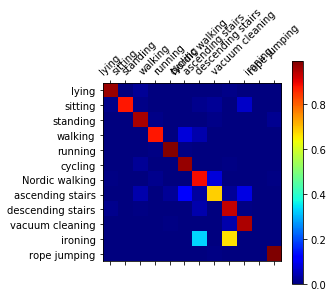

In [98]:
# rope jumping corrupting color scheme
cm  = create_conf_matrix(y_true_np,y_pred_np,n_classes=len(activities))
cmdf = pd.DataFrame(cm/cm.sum(1)[:, None])
cmdf.columns = activities
cmdf.index = activities

plot_confusion_matrix(cmdf)

In [99]:
print("%s\t%d\t%.4f\t%.4f" %(model.__class__.__name__,num_classes,np.mean(fm_score),acc))

IsotropyNet	12	0.8385	0.9318


## History of best Results (win_size = 256)

% model.__class__.__name__,num_classes,np.mean(fm_score),acc)
<br>
<br>
<pre>
IsotropyNet64   	12	0.8477	0.9444
Conv1DNet           12	0.8437	0.9380
MultiSincNet	    12	0.8658	0.9546
Conv1DLstmNet       12	0.9188	0.9318
MultiSincLstmNet	12	0.9219	0.9362
</pre>
<br>
<pre>
Conv1DNet	       4	0.9967	0.9960
MultiSincNet        4	0.9837	0.9855
Conv1DLstmNet	   4	0.9848	0.9868
MultiSincLstmNet	4	0.9934	0.9921
</pre>

## some inference

In [0]:
assert

SyntaxError: ignored

In [0]:
def transform_csv(path):
    new_col_names = ["time", "hand_accelerometer", "hand_magnetometer", "hand_gyroscope", "ankle_accelerometer", "ankle_magnetometer", "ankle_gyroscope", "chest_accelerometer","chest_magnetometer", "chest_gyroscope"]
    replaced_cols = ["time", "hand_accelerometer", "hand_gyroscope", "hand_magnetometer", "ankle_accelerometer", "ankle_gyroscope","ankle_magnetometer",  "chest_accelerometer", "chest_gyroscope","chest_magnetometer"]
        
    def column_transform(data,col_name):
        if col_name != "time":
            new = data[col_name].str.replace(")","").str.replace("(","").str.replace(" ","").str.split(",", n = 2, expand = True) 
            data[col_name + "_x"] = new[0]
            data[col_name + "_y"] = new[1]
            data[col_name + "_z"] = new[2]
            data.drop(columns =[col_name], inplace = True) 
        return data
    
    data = pd.read_csv(path)
    
    data = data.rename(index=str,columns = dict(zip(list(data.columns),new_col_names)))
    
    data = data[replaced_cols]
    


    for col in data.columns:
        data = column_transform(data, col)
    return data

In [0]:
data = transform_csv('/ksozykinraid/src/real_run.csv')
data = data.drop(['time'],1)
data = data.values.astype('float32')

In [0]:
batch = []
for window in sliding_window(data,win_size=win_size,step=5):
    batch.append(window)
batch = torch.tensor(np.array(batch)).to(device)
batch = batch.transpose(2,1)

In [0]:
batch.shape

In [0]:
torch.argmax(model(batch).softmax(-1),-1)

In [0]:
[activities[int(e)] for e in torch.argmax(model(batch).softmax(-1),-1)]